### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

In [27]:
#Remaining setup
import numpy as np
import scipy
from matplotlib import pyplot as plt
import sklearn

#sklearn specific stuff that I may change the formating of later
#normally I prefer to have the full call since it's way clearer to me. 
#but this is the way the lecture had it, so I'll stick with it this time. 
from sklearn.neighbors import KernelDensity
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # gridsearch is about parameter tuning. 
from sklearn.mixture import GaussianMixture

from astroML.density_estimation import KNeighborsDensity

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

(1000, 3)
[-8.46474567 -3.45517123  1.        ]


Text(0.5, 1.0, 'Split and Labeled Data')

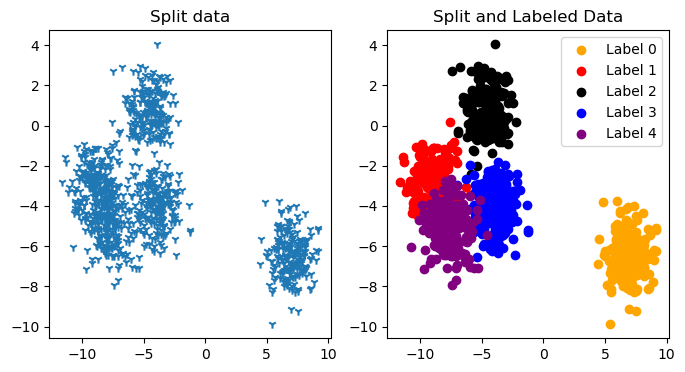

In [11]:
#PART 1

data = np.load("/Users/katiebarnhart/Documents/hw6_data_1.npy")

#get an idea of what this data is 
print(np.shape(data))
print(data[0])

#split this up
data_x = data[:,0]
data_y = data[:,1]
data_labels = data[:,2]

#some histograms
#pull code from near the top of lecture 14, which includes a lot of stuff on KDE
#and from other lectures
fig = plt.figure(figsize=(8,4))

ax = fig.add_subplot(121)
ax.scatter(data_x, data_y, marker="1")
ax.set_title("Split data")

#figure out how to colorplot this and change the marker style with color

a = data[:,2]==0
b = data[:,2]==1
c = data[:,2]==2
d = data[:,2]==3
e = data[:,2]==4

data_a = data[a]
data_b = data[b]
data_c = data[c]
data_d = data[d]
data_e = data[e]

ax = fig.add_subplot(122)
ax.scatter(data_a[:,0],data_a[:,1], c = "orange", label = "Label 0")
ax.scatter(data_b[:,0],data_b[:,1], c = "red", label = "Label 1")
ax.scatter(data_c[:,0],data_c[:,1], c = "black", label = "Label 2")
ax.scatter(data_d[:,0],data_d[:,1], c = "blue", label = "Label 3")
ax.scatter(data_e[:,0],data_e[:,1], c = "purple", label = "Label 4")
ax.legend()
ax.set_title("Split and Labeled Data")
#thats a lot clearer

The ideal bandwidth is: 0.4413793103448276


Text(0.5, 1.0, '2-D KDE plot using optimal bandwidth')

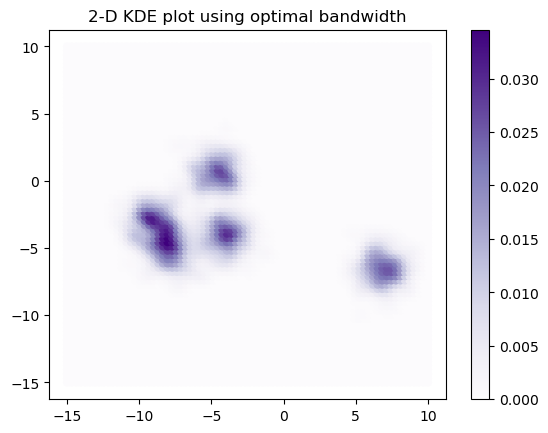

In [17]:
# PART 2

#kernal bandwidth
#from lecture 14: "How do we determine the optimal kernel bandwidth?"
x = np.concatenate([data[:,0], data[:,1]])
bwrange = np.linspace(0.1, 1.0, 30) #Test 30 bandwidths from 0.1 to 1.0
K = 5 #Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=5) #Try each bandwidth with K-folds
grid.fit(x[:, None])
h_opt = grid.best_params_['bandwidth'] #this actually does the calculation of optimal bandwidth
print("The ideal bandwidth is:", h_opt)

#fits
#from lecture 14: "2-D histograms"
X = np.vstack((data[:,0], data[:,1])).T #VSTACK!!!
kde = KernelDensity(kernel = 'gaussian', bandwidth = h_opt)
kde.fit(X) #Fitting the data

u = v = np.linspace(-15, 10, 80)
xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(xgrid)) #evaluate the model on the grid

#plots
plt.scatter(xgrid[:,0], xgrid[:,1], c = dens, cmap = "Purples", edgecolor = "None")
plt.colorbar()
plt.title("2-D KDE plot using optimal bandwidth")

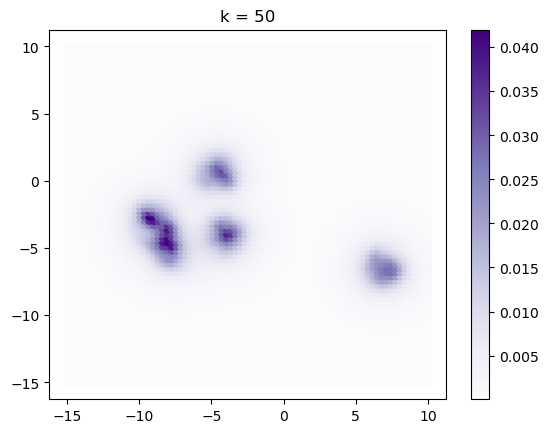

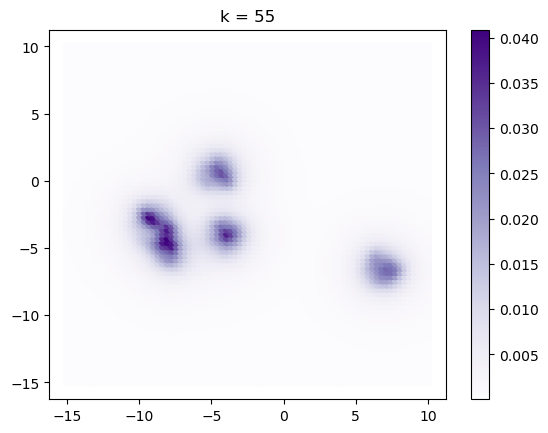

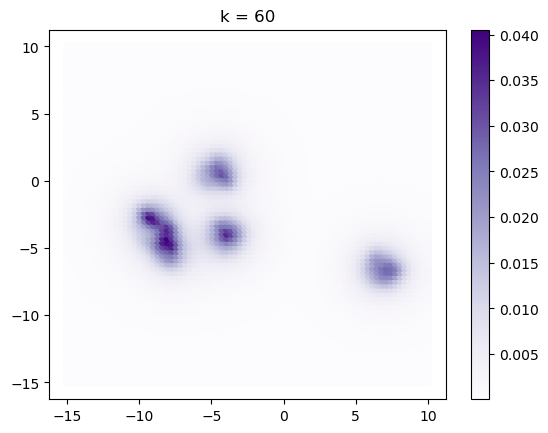

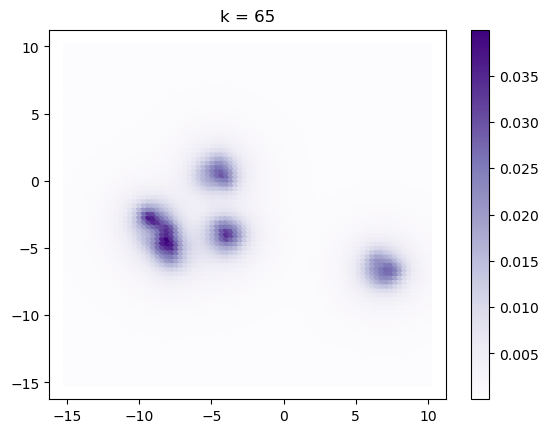

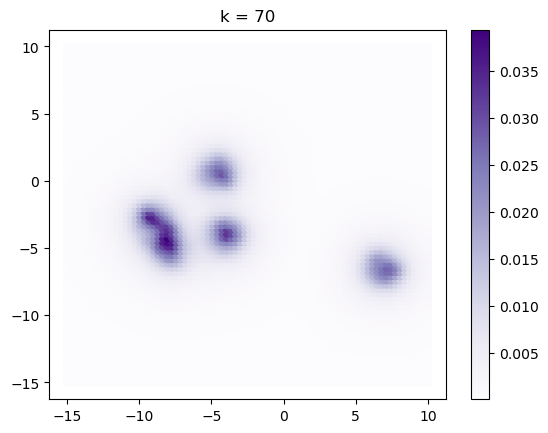

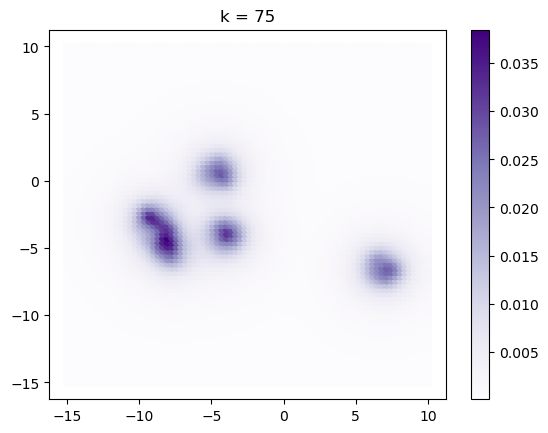

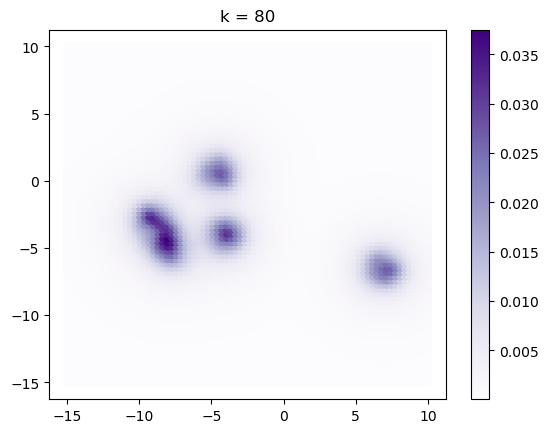

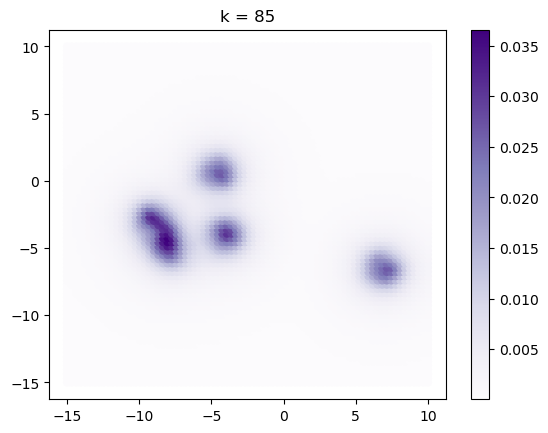

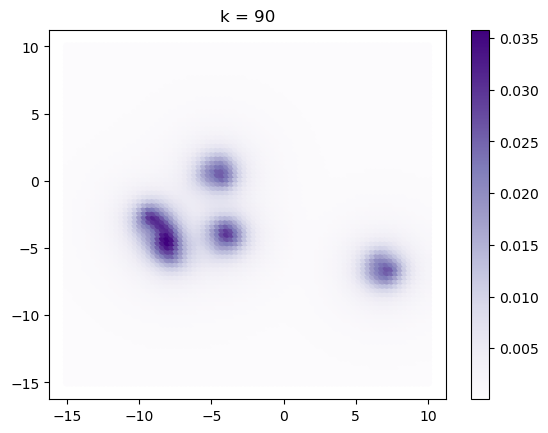

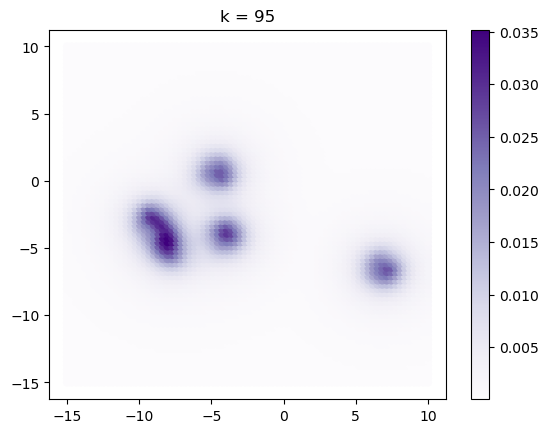

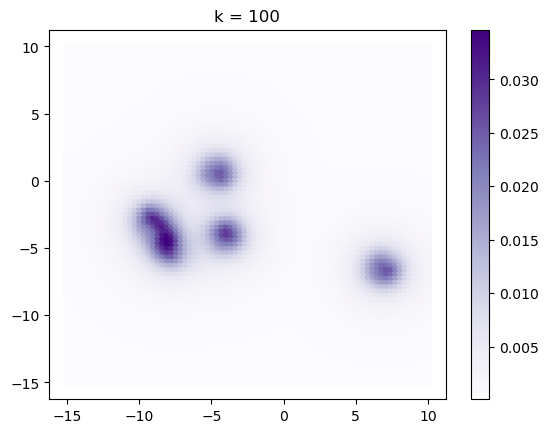

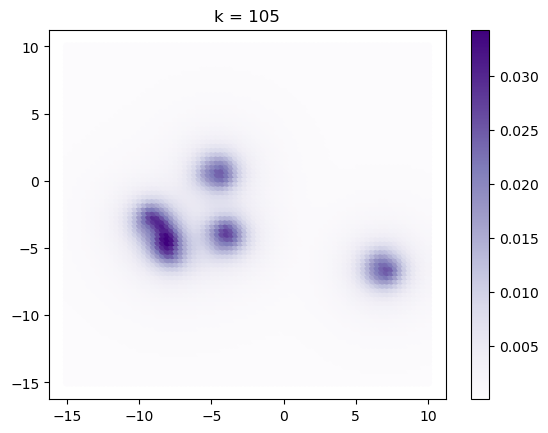

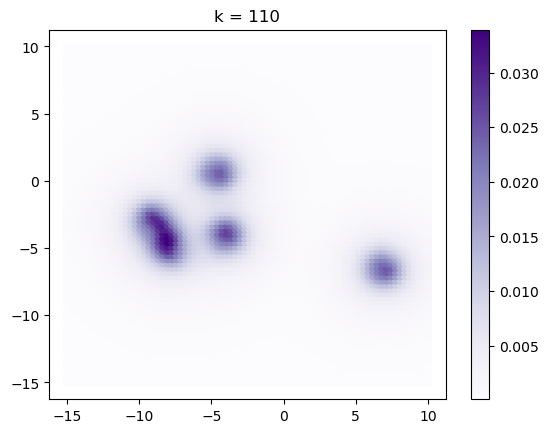

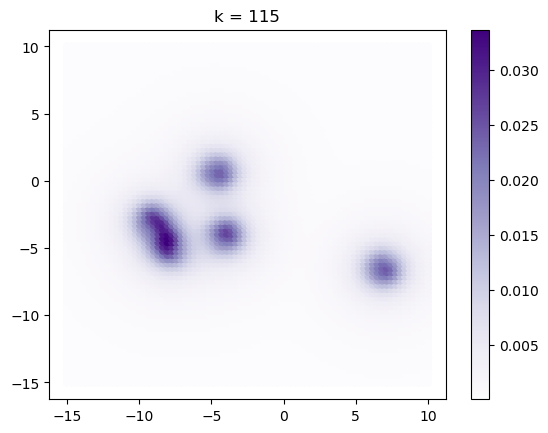

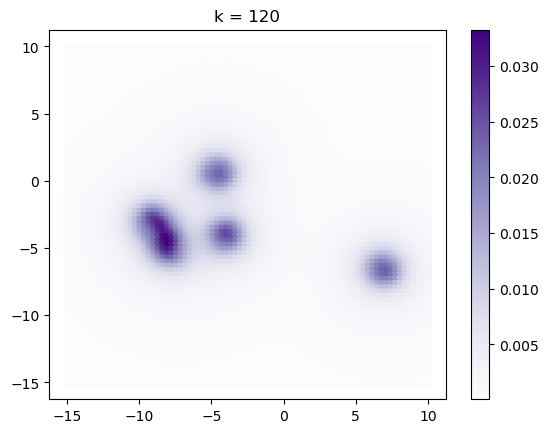

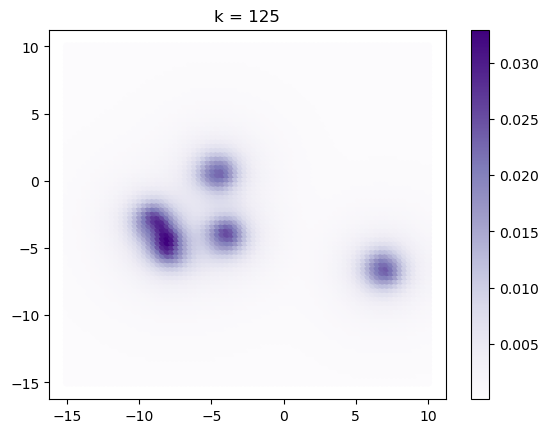

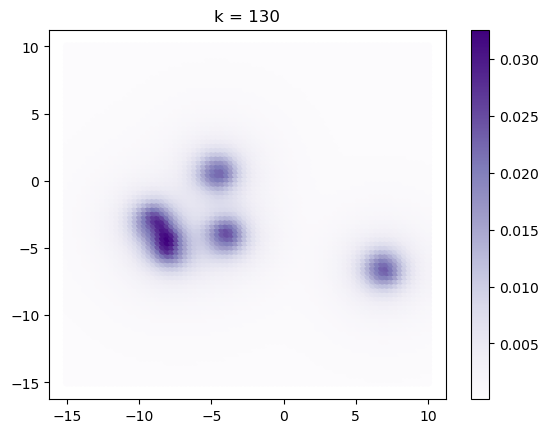

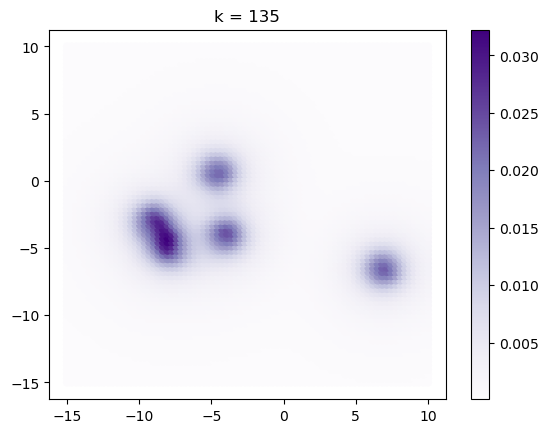

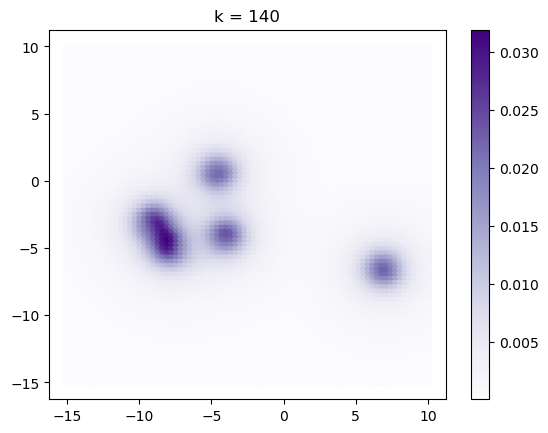

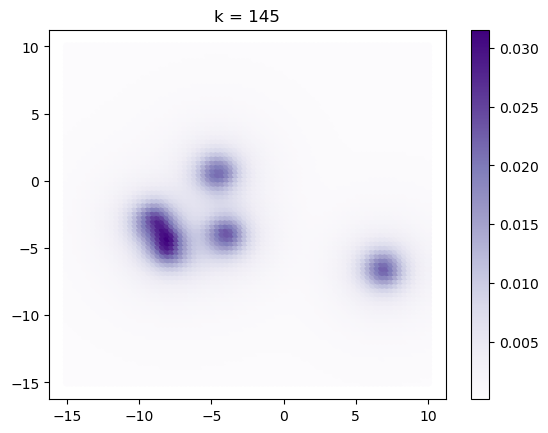

In [25]:
#PART 3

#from lecture 14: "Nearest-Neighbor Density Estimation"
#and from Anthony's suggestion to just go ahead and use a loop since that's SO much easier. 
N = 1000
k = np.arange(50, 150, 5)

for i in k:
    #print(i)
    nbrs = KNeighborsDensity("bayesian", n_neighbors=i)
    nbrs.fit(X)
    uu = vv = np.linspace(-15, 10, 80)
    np.vstack(list(map(np.ravel, np.meshgrid(uu, vv)))).T
    dens = nbrs.eval(xgrid) / N
    plt.figure(i)
    plt.scatter(xgrid[:,0], xgrid[:,1], c = dens, cmap = "Purples", edgecolor = "none")
    plt.colorbar()
    plt.title("k = " + str(i))


In [24]:
#PART 3 continued

print("best K nearest neighbors looks to be 75 or 80")

best K nearest neighbors looks to be 75 or 80


4 components is best.


<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_0/n4fgknn14j7c9wgk4lfg4kb40000gn/T/ipykernel_35762/3685736957.py:37: SyntaxWarning: invalid escape sequence '\s'
  draw_ellipse(m, c, scales = [2], ax = None, color = "grey", label = '2$\sigma$')


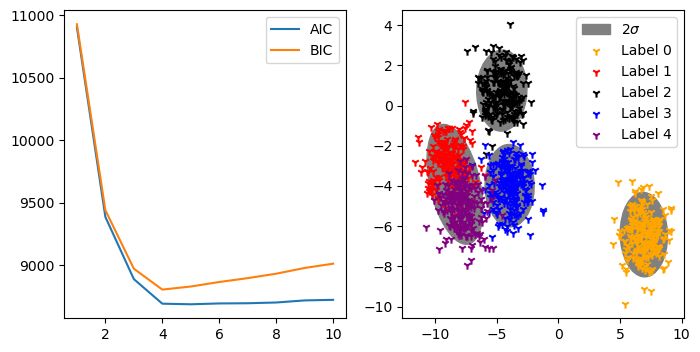

In [34]:
#PART 4

#from lecture 14: "Parametric Density Estimation"
#setup
X = np.vstack((data[:,0], data[:,1])).T #lets be careful
N = np.arange(1, 11) #problem asks for 10 components
models = [None for i in range(len(N))]
#fits
for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

#plots
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121)
ax.plot(N, AIC, label = 'AIC')
ax.plot(N, BIC, label = 'BIC')
ax.legend()
print("4 components is best.")

#fits, again
means = GaussianMixture(n_components= 4, covariance_type= 'full').fit(X)
n  = np.linspace(-15, 10, 1000)
mu = means.means_
C  = means.covariances_

#aaaand plots, again
ax = fig.add_subplot(122)
#drawing elipses. debugging thanks goes to Anthony, again. 
for j in range(len(mu)):
    m = mu[j]
    c = C[j]
    if j == 0:
        draw_ellipse(m, c, scales = [2], ax = None, color = "grey", label = '2$\sigma$')
    else:
        draw_ellipse(m, c, scales = [2], ax = None, color = 'grey')
ax.scatter(data_a[:,0],data_a[:,1], marker = "1", c = "orange", label = "Label 0")
ax.scatter(data_b[:,0],data_b[:,1], marker = "1", c = "red", label = "Label 1")
ax.scatter(data_c[:,0],data_c[:,1], marker = "1", c = "black", label = "Label 2")
ax.scatter(data_d[:,0],data_d[:,1], marker = "1", c = "blue", label = "Label 3")
ax.scatter(data_e[:,0],data_e[:,1], marker = "1", c = "purple", label = "Label 4")
ax.legend()

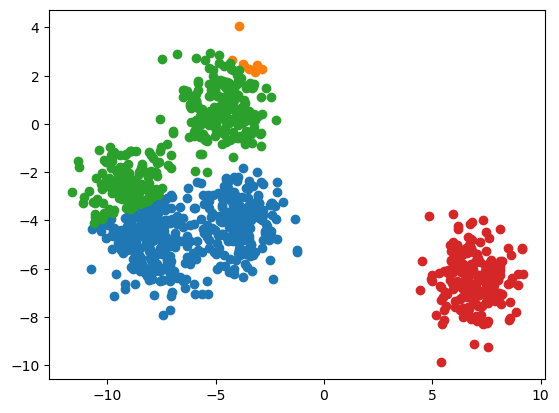

In [36]:
#PART 5

#setup
#from lecture 14: "K-Means Clustering"
from sklearn.cluster import KMeans
from sklearn import preprocessing
X = np.vstack((data[:,0], data[:,1])).T

#kmeans
scale = preprocessing.StandardScaler()
#thanks to https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
clf = KMeans(n_clusters=4)
clf.fit(scale.fit_transform(X)) 

#centers + transformed centers
centers = clf.cluster_centers_ #location of the clusters
trans_centers = scale.inverse_transform(centers)

#labels
labels = clf.predict(X) #labels, not sure if this is right. 

#plots, from lecture 14
fig1 = plt.figure()
colors = ['C0', 'C1', 'C2', 'C3']
for ii in range(4):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], color=colors[ii])

<span style="color:green"> NP: Correct! Good job! </span>